In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [2]:

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return x

In [3]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv_block(x)
        p = self.pool(x)
        return x, p

In [4]:
class ConvLSTM(nn.Module):
    def __init__(self, in_channels, hidden_channels, kernel_size, padding):
        super(ConvLSTM, self).__init__()
        self.conv = nn.Conv2d(in_channels + hidden_channels, 4 * hidden_channels, kernel_size, padding=padding)

    def forward(self, x, hidden):
        combined_input = torch.cat([x, hidden[0]], dim=1)
        gates = self.conv(combined_input)
        ingate, forgetgate, cellgate, outgate = torch.split(gates, gates.size(1) // 4, dim=1)
        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)
        cell = forgetgate * hidden[1] + ingate * cellgate
        hidden = outgate * torch.tanh(cell)
        return hidden, cell

In [5]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv_lstm = ConvLSTM(in_channels=out_channels, hidden_channels=out_channels, kernel_size=3, padding=1)

    def forward(self, x, skip, hidden=None, cell=None):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        if hidden is not None and cell is not None:
            x, _ = self.conv_lstm(x, (hidden, cell))
        return x


In [6]:
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=2, stride=2, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        psi = F.interpolate(psi, size=x.size()[2:], mode='bilinear', align_corners=True)
        return x * psi

In [7]:
class ASPPBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPPBlock, self).__init__()
        self.conv1x1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

        self.conv3x3_1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=6, dilation=6, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

        self.conv3x3_2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=12, dilation=12, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

        self.conv3x3_3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=18, dilation=18, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

        self.output_conv = nn.Sequential(
            nn.Conv2d(out_channels * 4, out_channels, kernel_size=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x1 = self.conv1x1(x)
        x2 = self.conv3x3_1(x)
        x3 = self.conv3x3_2(x)
        x4 = self.conv3x3_3(x)
        x = torch.cat((x1, x2, x3, x4), dim=1)
        x = self.output_conv(x)
        return x

In [8]:
class SiameseUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SiameseUNet, self).__init__()
        self.encoder1_1 = EncoderBlock(in_channels, 32)  
        self.encoder1_2 = EncoderBlock(32, 64)          
        self.encoder1_3 = EncoderBlock(64, 128)        
        self.encoder1_4 = EncoderBlock(128, 256)        

        self.encoder2_1 = EncoderBlock(in_channels, 32)  
        self.encoder2_2 = EncoderBlock(32, 64)          
        self.encoder2_3 = EncoderBlock(64, 128)         
        self.encoder2_4 = EncoderBlock(128, 256)        

        self.aspp = ASPPBlock(256 * 2, 512)             

        self.attn1 = AttentionBlock(512, 256 * 2, 256)  
        self.attn2 = AttentionBlock(256, 128 * 2, 128)  
        self.attn3 = AttentionBlock(128, 64 * 2, 64)    
        self.attn4 = AttentionBlock(64, 32 * 2, 32)     

        self.decoder1 = DecoderBlock(512 + 512, 256)    
        self.decoder2 = DecoderBlock(256 + 256, 128)    
        self.decoder3 = DecoderBlock(128 + 128, 64)     
        self.decoder4 = DecoderBlock(64 + 64, 32)       

        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=1)  # Assuming output channels remain 1

    def forward(self, x1, x2):
        # Encoder Path
        s1_1, p1_1 = self.encoder1_1(x1)
        s2_1, p2_1 = self.encoder1_2(p1_1)
        s3_1, p3_1 = self.encoder1_3(p2_1)
        s4_1, p4_1 = self.encoder1_4(p3_1)

        s1_2, p1_2 = self.encoder2_1(x2)
        s2_2, p2_2 = self.encoder2_2(p1_2)
        s3_2, p3_2 = self.encoder2_3(p2_2)
        s4_2, p4_2 = self.encoder2_4(p3_2)

        # ASPP
        concatenated = torch.cat((p4_1, p4_2), dim=1)
        b1 = self.aspp(concatenated)

        # Decoder Path with Attention
        attn_s4 = self.attn1(b1, torch.cat((s4_1, s4_2), dim=1))
        d1 = self.decoder1(b1, attn_s4)

        attn_s3 = self.attn2(d1, torch.cat((s3_1, s3_2), dim=1))
        d2 = self.decoder2(d1, attn_s3)

        attn_s2 = self.attn3(d2, torch.cat((s2_1, s2_2), dim=1))
        d3 = self.decoder3(d2, attn_s2)

        attn_s1 = self.attn4(d3, torch.cat((s1_1, s1_2), dim=1))
        d4 = self.decoder4(d3, attn_s1)

        outputs = torch.sigmoid(self.final_conv(d4))
        return outputs


In [9]:
import os
def load_checkpoint(filename, model, optimizer=None):
    if os.path.isfile(filename):
        print(f"Loading checkpoint '{filename}'")
        # Load the checkpoint with map_location=torch.device('cpu')
        checkpoint = torch.load(filename, map_location=torch.device('cpu'))
        if model is not None:
            model.load_state_dict(checkpoint['state_dict'])
        if optimizer is not None and 'optimizer' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer'])
        print(f"Loaded checkpoint '{filename}' (epoch {checkpoint['epoch']})")
    else:
        print(f"No checkpoint found at '{filename}'")


In [10]:
import torchvision.transforms as transforms
# Define the transformations (resize and convert to tensor)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [11]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Assuming SiameseUNet and related classes are defined as in your provided code
# Define the model
model = SiameseUNet(in_channels=3, out_channels=1)

# Load the model checkpoint
model_save_path = '/Users/sampreethshetty/Documents/cd_rs/siamese_unet_best_model.pth'
load_checkpoint(model_save_path, model, optimizer=None)

# Set the model to evaluation mode
model.eval()
model.to(device)

Loading checkpoint '/Users/sampreethshetty/Documents/cd_rs/siamese_unet_best_model.pth'
Loaded checkpoint '/Users/sampreethshetty/Documents/cd_rs/siamese_unet_best_model.pth' (epoch 3)


SiameseUNet(
  (encoder1_1): EncoderBlock(
    (conv_block): ConvBlock(
      (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder1_2): EncoderBlock(
    (conv_block): ConvBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, c

In [21]:
from PIL import Image


# Load the images
def load_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image.to(device)

# Example image paths
time1_image_path = '/Users/sampreethshetty/Documents/cd_rs/dataset/sysu-cd/test/time1/01070.png'
time2_image_path = '/Users/sampreethshetty/Documents/cd_rs/dataset/sysu-cd/test/time2/01070.png'
original_label = '/Users/sampreethshetty/Documents/cd_rs/dataset/sysu-cd/test/lABEL/01070.png'
# Preprocess the images
time1_image = load_image(time1_image_path, transform)
time2_image = load_image(time2_image_path, transform)


In [22]:
# Make predictions
with torch.no_grad():
    output = model(time1_image, time2_image)

# Convert the output to a binary mask (if required)
prediction = (output > 0.5).float()

# To convert the tensor to a numpy array (for further processing or saving the output image)
prediction_np = prediction.squeeze().cpu().numpy()

# Optionally, save the output prediction as an image
import numpy as np
from PIL import Image

prediction_image = Image.fromarray((prediction_np * 255).astype(np.uint8))
predicted_label='/Users/sampreethshetty/Downloads/predict.png'
prediction_image.save(predicted_label)


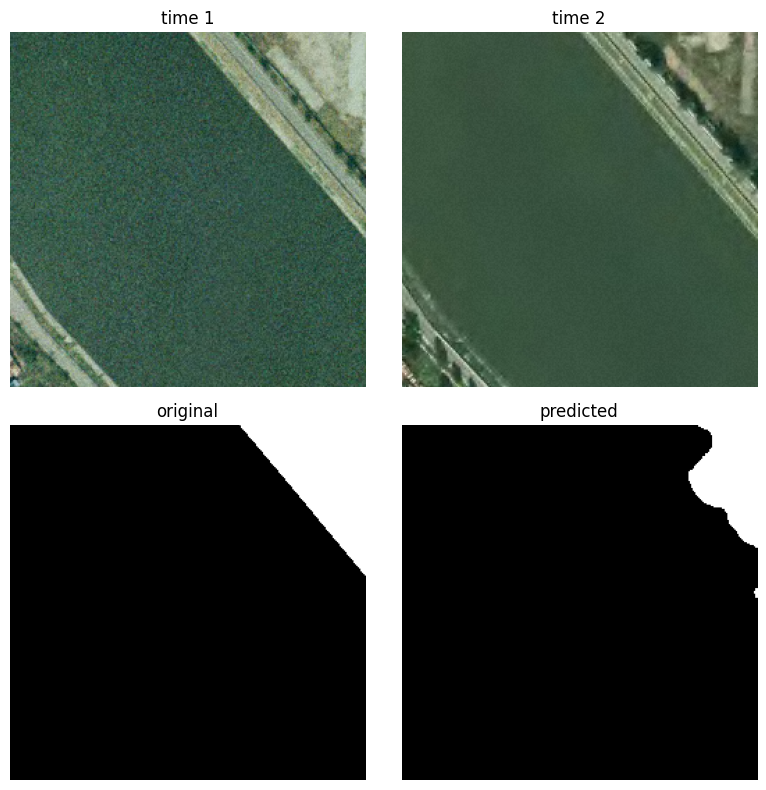

In [23]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def plot_images_from_paths(time1_image_path, time2_image_path, original_label, predicted_label):
   
    # Load the images
    rgb_image1 = Image.open(time1_image_path)
    rgb_image2 = Image.open(time2_image_path)
    single_channel_image1 = Image.open(original_label).convert('L')
    single_channel_image2 = Image.open(predicted_label).convert('L')
    
    # Create a 2x2 subplot
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))

    # Plot each image
    axes[0, 0].imshow(rgb_image1)
    axes[0, 0].set_title('time 1')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(rgb_image2)
    axes[0, 1].set_title('time 2')
    axes[0, 1].axis('off')

    # For single-channel images, use cmap='gray'
    axes[1, 0].imshow(single_channel_image1, cmap='gray')
    axes[1, 0].set_title('original')
    axes[1, 0].axis('off')

    axes[1, 1].imshow(single_channel_image2, cmap='gray')
    axes[1, 1].set_title('predicted')
    axes[1, 1].axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.show()


plot_images_from_paths(time1_image_path, time2_image_path, original_label, predicted_label)
